# Importando bibliotécas

In [116]:
import re
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy


In [41]:
DATASET_PATH = os.path.join(os.getcwd(), 'datasets')

In [90]:

dataset_train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'), encoding='UTF-8')
# dataset_test = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'), encoding='UTF-8')
# dataset_test_target = pd.read_csv(os.path.join(DATASET_PATH, 'sample_submission.csv'), encoding='UTF-8')
dataset_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# Análise exploratória

In [91]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [92]:
dataset_train.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

In [93]:
dataset_train['lenght'] = dataset_train.text.apply(len)
dataset_train

,id,keyword,location,text,target,lenght
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137


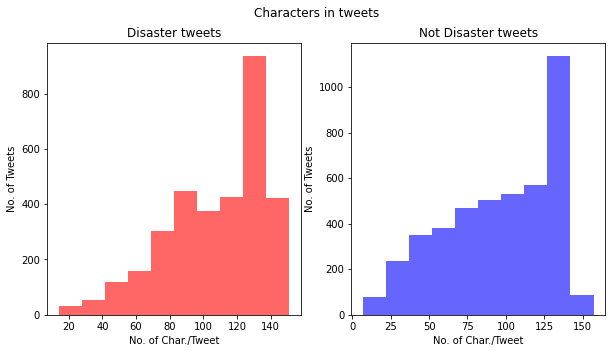

In [94]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=dataset_train[dataset_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red', alpha=0.6)
ax1.set_title('Disaster tweets')
ax1.set_xlabel('No. of Char./Tweet')
ax1.set_ylabel('No. of Tweets')
tweet_len=dataset_train[dataset_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='blue', alpha=0.6)
ax2.set_title('Not Disaster tweets')
ax2.set_xlabel('No. of Char./Tweet')
ax2.set_ylabel('No. of Tweets')
fig.suptitle('Characters in tweets')
plt.show()

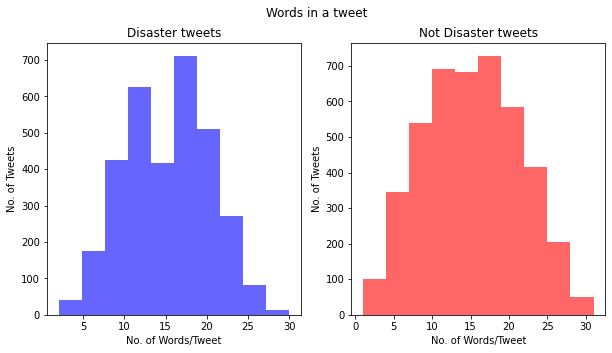

In [55]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=dataset_train[dataset_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue', alpha=0.6)
ax1.set_title('Disaster tweets')
ax1.set_xlabel('No. of Words/Tweet')
ax1.set_ylabel('No. of Tweets')
tweet_len=dataset_train[dataset_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red', alpha=0.6)
ax2.set_title('Not Disaster tweets')
ax2.set_xlabel('No. of Words/Tweet')
ax2.set_ylabel('No. of Tweets')
fig.suptitle('Words in a tweet')
plt.show()

# Pré-processamento do Texto

In [95]:
dataset_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
lenght         0
dtype: int64

In [96]:
dataset_train['keyword'] = dataset_train['keyword'].fillna('')

In [99]:
# dataset_train_nn = dataset_train[(dataset_train['keyword'] != '')]
dataset_train

,id,keyword,location,text,target,lenght
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...,...,...
7608,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,10872,,NaN,Police investigating after an e-bike collided ...,1,137


## Limpando Caorpus

In [98]:
def clean_text(text):
   '''Tranformar o texto em letras minúsculas, remover texto entre colchetes, remover links, 
       remover pontuação e remover palavras que contenham números.'''

   text = str(text).lower()
   text = re.sub('\[.*?\]', '', text)
   text = re.sub('https?://\S+|www\.\S+', '', text)
   text = re.sub('<.*?>+', '', text)
   text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
   text = re.sub('\n', '', text)
   text = re.sub('\w*\d\w*', '', text)
   return text


In [100]:
dataset_train['text_clean'] = dataset_train['text'].apply(clean_text)
dataset_train

,id,keyword,location,text,target,lenght,text_clean
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,our deeds are the reason of this earthquake ma...
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,133,all residents asked to shelter in place are be...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders in...
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...,...
7608,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,83,two giant cranes holding a bridge collapse int...
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrary thetawniest the out of control wild...
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,s of volcano hawaii
7611,10872,,NaN,Police investigating after an e-bike collided ...,1,137,police investigating after an ebike collided w...


## Remoção de stopwords

In [101]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords


def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brpep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
dataset_train['text_clean'] = dataset_train['text_clean'].apply(remove_stopwords)
dataset_train

,id,keyword,location,text,target,lenght,text_clean
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders ca...
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...
7608,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,83,two giant cranes holding bridge collapse nearb...
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrary thetawniest control wild fires cali...
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,volcano hawaii
7611,10872,,NaN,Police investigating after an e-bike collided ...,1,137,police investigating ebike collided car little...


## 🛠 Lematização

In [103]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [104]:
dataset_train['text_clean'] = dataset_train['text_clean'].apply(stemm_text)
dataset_train

,id,keyword,location,text,target,lenght,text_clean
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquak may allah forgiv us
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la rong sask canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,133,resid ask shelter place notifi offic evacu she...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,65,peopl receiv wildfir evacu order california
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...,...,...
7608,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,83,two giant crane hold bridg collaps nearbi home
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrari thetawniest control wild fire calif...
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,volcano hawaii
7611,10872,,NaN,Police investigating after an e-bike collided ...,1,137,polic investig ebik collid car littl portug eb...


In [105]:
X = dataset_train.text_clean
y = dataset_train.target

print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5709,)
(5709,)
(1904,)
(1904,)


In [113]:
model_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
sentence_encoder_layer = hub.KerasLayer(model_url, input_shape = [], dtype = tf.string, trainable = False)

In [118]:
model = keras.Sequential([
    sentence_encoder_layer,
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = BinaryCrossentropy(from_logits = True),
    optimizer = keras.optimizers.Adam(learning_rate= 1e-4),
    metrics = ['accuracy']
)

In [119]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147,428,865
Trainable params: 73,985
Non-trainable params: 147,354,880
_________________________________________________________________


In [120]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)